# GB_filtered Visualization

## How are foreign countries referenced in parliamentary debates?
### 1. Frequency of Mentions: 
Show which foreign countries or regions are most frequently mentioned.
### 2. Distribution by Political Party: 
Illustrate how mentions of foreign countries vary across different political parties to identify potential partisan differences in focus.

## Preprocessing: 
Convert to Lowercase;
Handle Abbreviations and Synonyms;
Filter for Foreign Countries.

In [11]:
import pandas as pd


df = pd.read_csv("GB.csv")
print(df["entity"].unique())

['europe' 'eu' 'west africa' 'africa' 'libya' 'north africa' 'south sudan'
 'cayman islands' 'vatican' 'puerto rico' 'north america' 'south america'
 'aruba' 'isle of man' 'channel islands' 'antarctica' 'faroe islands'
 'guernsey' 'jersey' 'martinique' 'pitcairn' 'bermuda' 'montserrat'
 'south australia' 'east africa' 'laos' 'dominica' 'anguilla' 'west asia'
 'christmas island' 'south asia' 'new zealand' 'western sahara'
 'guadeloupe' 'oceania' 'united states' 'united nations' 'sint maarten'
 'northern europe' 'east asia' 'eswatini' 'north macedonia'
 'south west africa' 'southern africa' 'dr congo' 'southern europe'
 'türkiye']


In [12]:
# %pip install pycountry

Case Standardization: Converting all entries to lowercase ensures consistency and avoids duplicates due to case differences.

Custom Mapping: A dictionary is used to handle non-standard names (e.g., "türkiye" to "Turkey"), regions (e.g., "europe" to "Region: Europe"), and territories (e.g., "bermuda" to "Territory: Bermuda (UK)"). This step is crucial for entities that pycountry cannot resolve.

Country Lookup with pycountry: For entities not in the custom mapping, pycountry is used to find the official country name. If no match is found, the entity is labeled as "Other" or kept with a prefix for clarity.

ISO Codes: Optionally, ISO codes (e.g., "USA" for United States) are extracted for countries, which can be useful for geographical visualizations (e.g., with plotly or geopandas).

In [13]:
import pandas as pd
import pycountry

entities = df["entity"]

# Step 1: Convert to lowercase for consistency
entities_normalized = entities.str.lower()

# Step 2: Custom mapping for non-standard names, regions, and special entities
custom_mapping = {
    "türkiye": "Turkey",
    "dr congo": "Congo, The Democratic Republic of the",
    "united states": "United States",
    "vatican": "Holy See",
    "south west africa": "Namibia",  # Historical name for Namibia
    "eu": "European Union",
    "united nations": "United Nations",
    "south australia": "South Australia",  # Could be treated as part of Australia if needed
    # Regions (categorize as 'Region' or exclude based on analysis goal)
    "europe": "Region: Europe",
    "southern europe": "Region: Southern Europe",
    "northern europe": "Region: Northern Europe",
    "africa": "Region: Africa",
    "east africa": "Region: East Africa",
    "west africa": "Region: West Africa",
    "north africa": "Region: North Africa",
    "southern africa": "Region: Southern Africa",
    "south america": "Region: South America",
    "north america": "Region: North America",
    "oceania": "Region: Oceania",
    "east asia": "Region: East Asia",
    "south asia": "Region: South Asia",
    "west asia": "Region: West Asia",
    "antarctica": "Region: Antarctica",
    # Territories (map to sovereign country or keep separate)
    "bermuda": "Territory: Bermuda (UK)",
    "cayman islands": "Territory: Cayman Islands (UK)",
    "anguilla": "Territory: Anguilla (UK)",
    "montserrat": "Territory: Montserrat (UK)",
    "pitcairn": "Territory: Pitcairn Islands (UK)",
    "channel islands": "Territory: Channel Islands (UK)",
    "guernsey": "Territory: Guernsey (UK)",
    "jersey": "Territory: Jersey (UK)",
    "isle of man": "Territory: Isle of Man (UK)",
    "faroe islands": "Territory: Faroe Islands (Denmark)",
    "puerto rico": "Territory: Puerto Rico (USA)",
    "guadeloupe": "Territory: Guadeloupe (France)",
    "martinique": "Territory: Martinique (France)",
    "aruba": "Territory: Aruba (Netherlands)",
    "sint maarten": "Territory: Sint Maarten (Netherlands)",
    "christmas island": "Territory: Christmas Island (Australia)"
}

# Step 3: Function to normalize entities using pycountry and custom mapping
def normalize_entity(entity):
    # Check if entity is in custom mapping
    if entity in custom_mapping:
        return custom_mapping[entity]
    try:
        # Try to find the country using pycountry
        country = pycountry.countries.lookup(entity)
        return country.name
    except LookupError:
        # If not found, return as is or categorize as 'Other'
        return f"Other: {entity.capitalize()}"

# Apply normalization
normalized_entities = entities_normalized.apply(normalize_entity)

# Step 4: Create a DataFrame to view original vs normalized
result_df = pd.DataFrame({
    'Original': entities,
    'Normalized': normalized_entities
})

# Display the results
print(result_df)

# Step 5: Optionally, extract ISO codes for countries (for mapping or visualization)
def get_iso_code(entity):
    try:
        if "Region:" in entity or "Territory:" in entity or "Other:" in entity:
            return None
        country = pycountry.countries.lookup(entity)
        return country.alpha_3
    except LookupError:
        return None

result_df['ISO_Code'] = result_df['Normalized'].apply(get_iso_code)
print("\nWith ISO Codes:")
print(result_df)


            Original             Normalized
0             europe         Region: Europe
1             europe         Region: Europe
2             europe         Region: Europe
3             europe         Region: Europe
4             europe         Region: Europe
...              ...                    ...
59151             eu         European Union
59152             eu         European Union
59153             eu         European Union
59154         europe         Region: Europe
59155  north america  Region: North America

[59156 rows x 2 columns]

With ISO Codes:
            Original             Normalized ISO_Code
0             europe         Region: Europe     None
1             europe         Region: Europe     None
2             europe         Region: Europe     None
3             europe         Region: Europe     None
4             europe         Region: Europe     None
...              ...                    ...      ...
59151             eu         European Union     None
59152

In [14]:
# Step 2: Define UK-related entities to exclude (considering UK territories as domestic)
uk_related = [
    "Territory: Bermuda (UK)",
    "Territory: Cayman Islands (UK)",
    "Territory: Anguilla (UK)",
    "Territory: Montserrat (UK)",
    "Territory: Pitcairn Islands (UK)",
    "Territory: Channel Islands (UK)",
    "Territory: Guernsey (UK)",
    "Territory: Jersey (UK)",
    "Territory: Isle of Man (UK)"
]
# Add explicit UK references if they appear in the full dataset
uk_related.extend(["United Kingdom", "Britain", "England", "Scotland", "Wales", "Northern Ireland"])

# Toggle: If you want to treat UK territories as foreign, set this to False
exclude_uk_territories = True

# Step 3: Filter for foreign entities
if exclude_uk_territories:
    foreign_filter = ~normalized_entities.isin(uk_related)
else:
    # If UK territories are considered foreign, only exclude explicit UK mainland references
    uk_mainland = ["United Kingdom", "Britain", "England", "Scotland", "Wales", "Northern Ireland"]
    foreign_filter = ~normalized_entities.isin(uk_mainland)

foreign_entities = pd.DataFrame({
    'Original': entities,
    'Normalized': normalized_entities,
    'Is_Foreign': foreign_filter
})

# Display the filtered results
print("All Entities with Foreign Classification:")
print(foreign_entities)

# Show only foreign entities
print("\nForeign Entities Only:")
print(foreign_entities[foreign_entities['Is_Foreign']])

# Step 4: Apply to full dataset 
df['Normalized_Entity'] = df['entity'].str.lower().apply(normalize_entity)
df_foreign = df[df['Normalized_Entity'].isin(foreign_entities[foreign_entities['Is_Foreign']]['Normalized'])]


All Entities with Foreign Classification:
            Original             Normalized  Is_Foreign
0             europe         Region: Europe        True
1             europe         Region: Europe        True
2             europe         Region: Europe        True
3             europe         Region: Europe        True
4             europe         Region: Europe        True
...              ...                    ...         ...
59151             eu         European Union        True
59152             eu         European Union        True
59153             eu         European Union        True
59154         europe         Region: Europe        True
59155  north america  Region: North America        True

[59156 rows x 3 columns]

Foreign Entities Only:
            Original             Normalized  Is_Foreign
0             europe         Region: Europe        True
1             europe         Region: Europe        True
2             europe         Region: Europe        True
3           

## Time-series plots: 
Show how mentions of foreign countries trend over time.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17772\3122367603.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foreign['Year'] = pd.to_datetime(df_foreign['Date']).dt.year


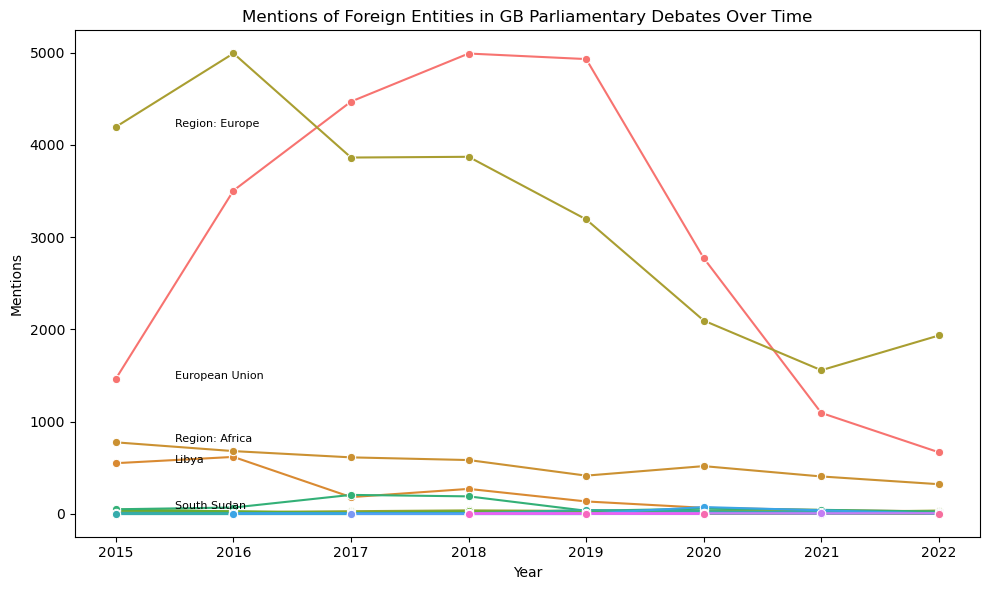

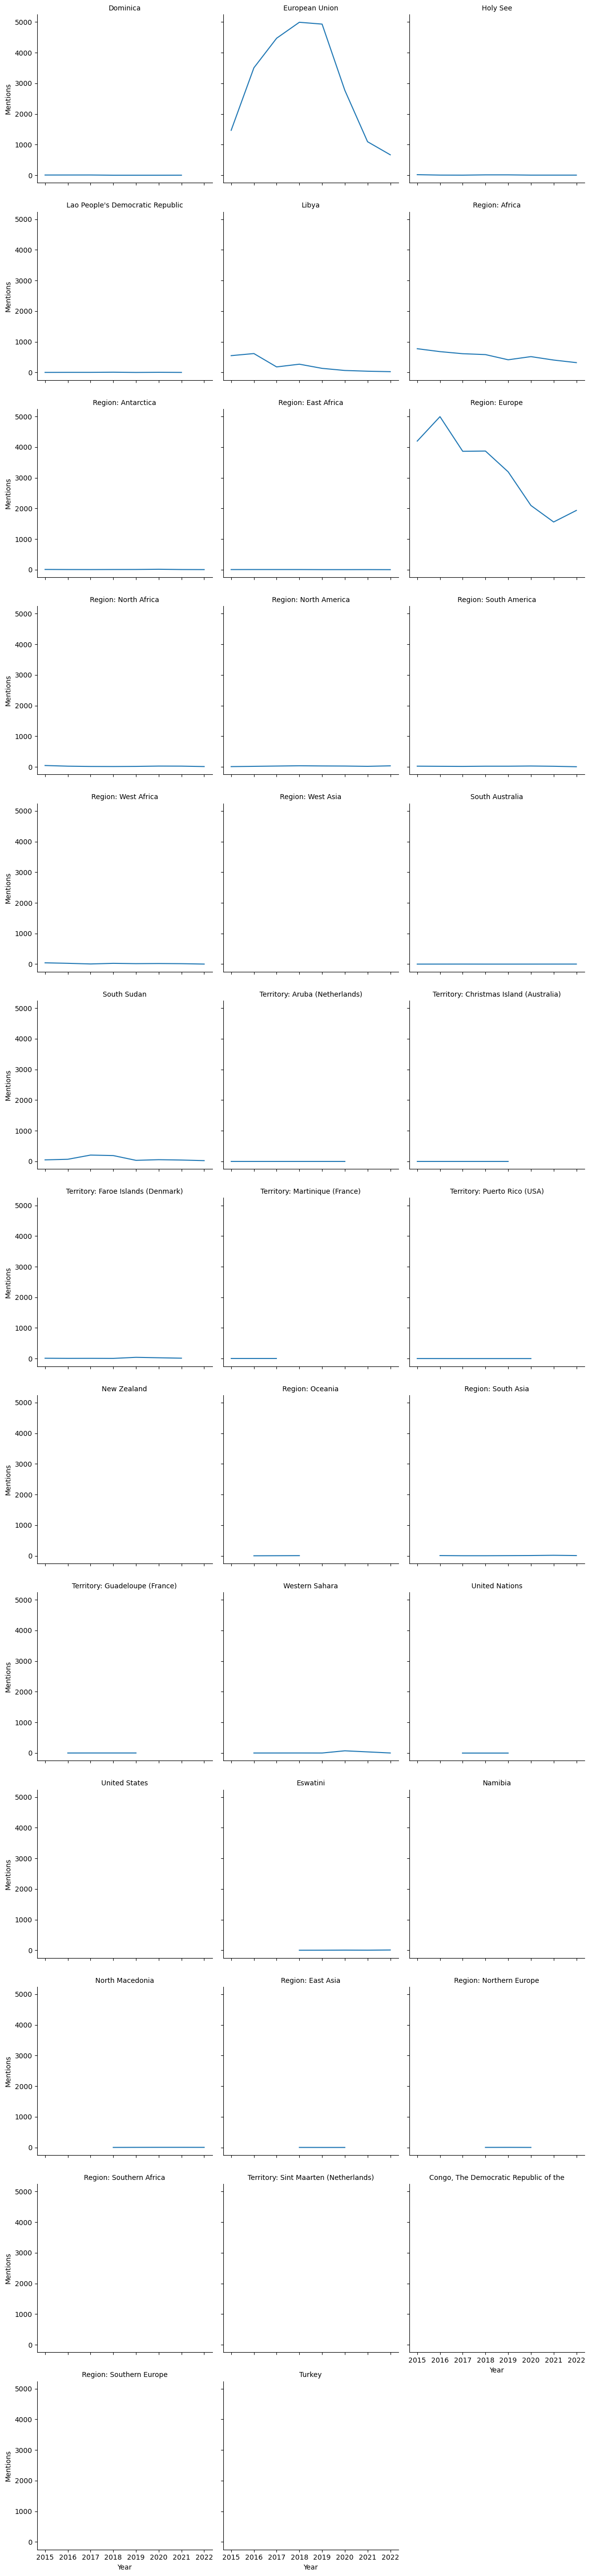

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

df_foreign['Year'] = pd.to_datetime(df_foreign['Date']).dt.year
mentions_by_year = df_foreign.groupby(['Year', 'Normalized_Entity']).size().reset_index(name='Mentions')

plt.figure(figsize=(10, 6))
sns.lineplot(data=mentions_by_year, x='Year', y='Mentions', hue='Normalized_Entity', marker='o')

ax = plt.gca()

top_entities = mentions_by_year.groupby('Normalized_Entity')['Mentions'].sum().nlargest(5).index
for entity in top_entities:
    # top 5 entities
    entity_data = mentions_by_year[mentions_by_year['Normalized_Entity'] == entity]
    first_point = entity_data.iloc[0]
    x = first_point['Year']
    y = first_point['Mentions']
    ax.text(x + 0.5, y + 0.5, entity, fontsize=8)


ax.get_legend().remove()

plt.title('Mentions of Foreign Entities in GB Parliamentary Debates Over Time')
plt.xlabel('Year')
plt.ylabel('Mentions')

plt.tight_layout()



g = sns.FacetGrid(mentions_by_year, col='Normalized_Entity', col_wrap=3, height=4)
g.map(plt.plot, 'Year', 'Mentions')
g.set_titles('{col_name}')
plt.show()


## Visualization 1 - Frequency of Mentions of Foreign Countries/Regions

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17772\4024567798.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=entity_freq.head(10), x='Mentions', y='Normalized_Entity', palette='Blues_d')


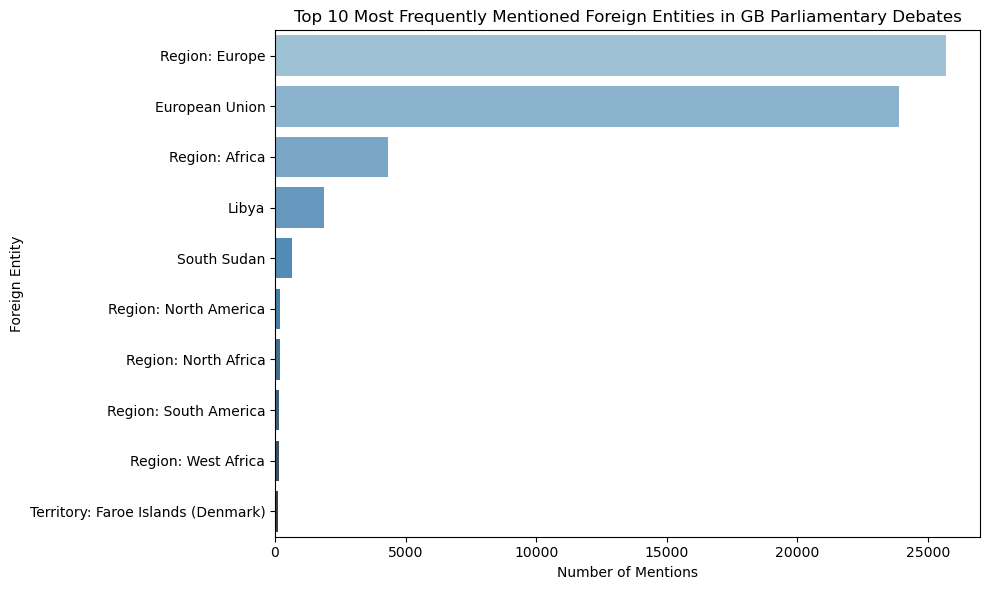

Frequency of Mentions for Foreign Entities:
                          Normalized_Entity  Mentions
0                            Region: Europe     25707
1                            European Union     23901
2                            Region: Africa      4307
3                                     Libya      1883
4                               South Sudan       666
5                     Region: North America       207
6                      Region: North Africa       179
7                     Region: South America       163
8                       Region: West Africa       155
9        Territory: Faroe Islands (Denmark)       113
10                           Western Sahara        79
11                                 Holy See        62
12                       Region: Antarctica        52
13                       Region: South Asia        48
14         Lao People's Democratic Republic        28
15                      Region: East Africa        27
16                          North Mace

In [16]:
entity_freq = df_foreign['Normalized_Entity'].value_counts().reset_index()
entity_freq.columns = ['Normalized_Entity', 'Mentions']

entity_freq = entity_freq.sort_values(by='Mentions', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=entity_freq.head(10), x='Mentions', y='Normalized_Entity', palette='Blues_d')
plt.title('Top 10 Most Frequently Mentioned Foreign Entities in GB Parliamentary Debates')
plt.xlabel('Number of Mentions')
plt.ylabel('Foreign Entity')
plt.tight_layout()
plt.show()

print("Frequency of Mentions for Foreign Entities:")
print(entity_freq)



## Visualization 2 - Distribution of Mentions by Political Party

Distribution of Mentions by Party and Entity:
                       Speaker_party_name    Normalized_Entity  Mentions
6                                       -          South Sudan        18
3                                       -       Region: Europe        17
0                                       -       European Union         5
2                                       -       Region: Africa         4
1                                       -                Libya         2
..                                    ...                  ...       ...
261  UK Independence Party;Non-affiliated  Region: West Africa         1
265                 Ulster Unionist Party       Region: Europe        37
263                 Ulster Unionist Party                Libya        35
262                 Ulster Unionist Party       European Union        27
264                 Ulster Unionist Party       Region: Africa         2

[266 rows x 3 columns]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17772\287315695.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


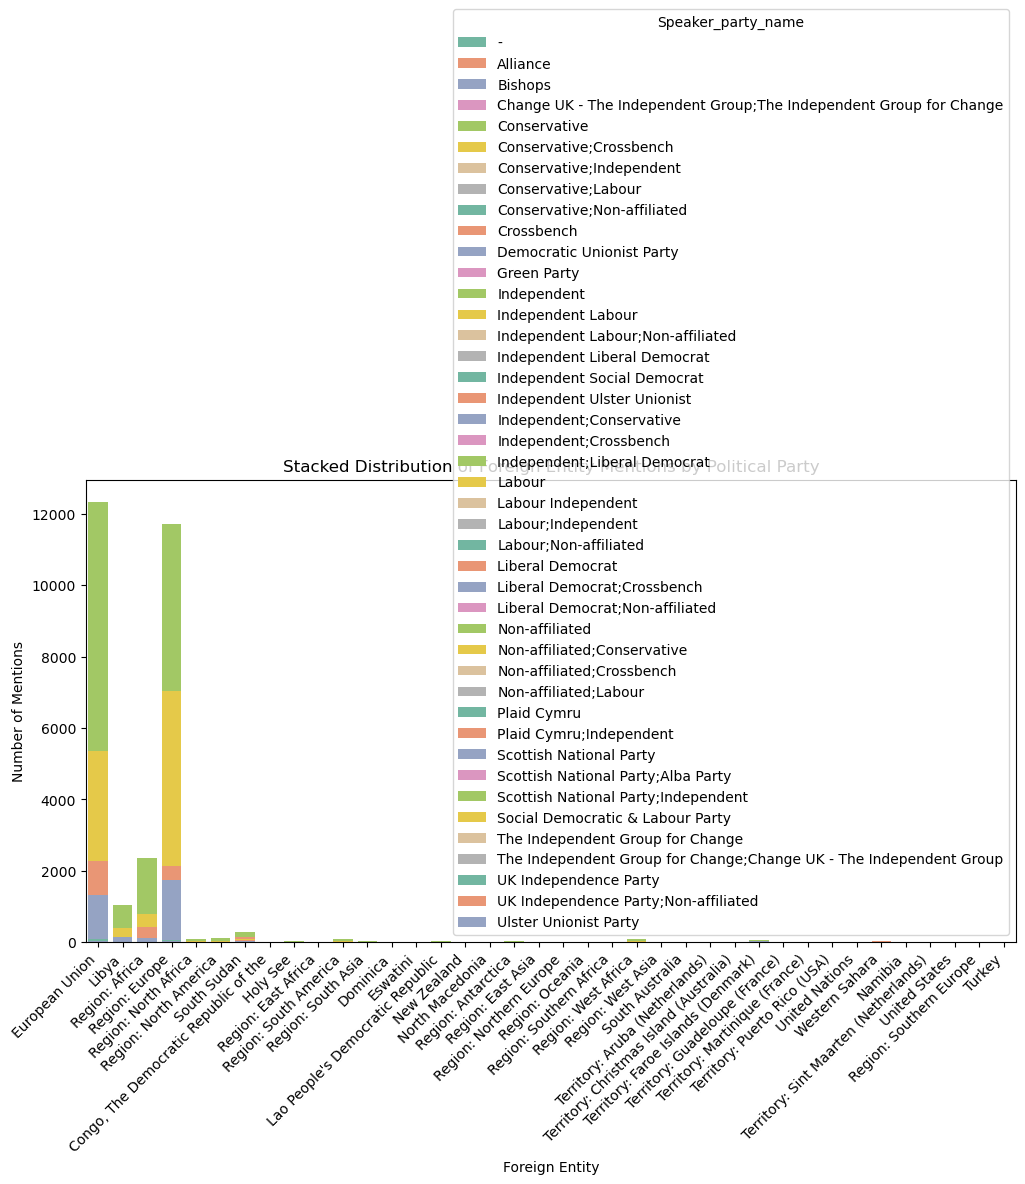

In [17]:
# Aggregate mentions by entity and party (focus on top 5 entities for clarity)
party_entity_dist = df_foreign.groupby(['Speaker_party_name', 'Normalized_Entity']).size().reset_index(name='Mentions')


print("Distribution of Mentions by Party and Entity:")
print(party_entity_dist.sort_values(by=['Speaker_party_name', 'Mentions'], ascending=[True, False]))

plt.figure(figsize=(12, 6))
sns.barplot(data=party_entity_dist, x='Normalized_Entity', y='Mentions', hue='Speaker_party_name', palette='Set2', dodge=False)
plt.title('Stacked Distribution of Foreign Entity Mentions by Political Party')
plt.xlabel('Foreign Entity')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## How do speaker-level variables (age, ideology, gender, ...) correlate with cross-national references?



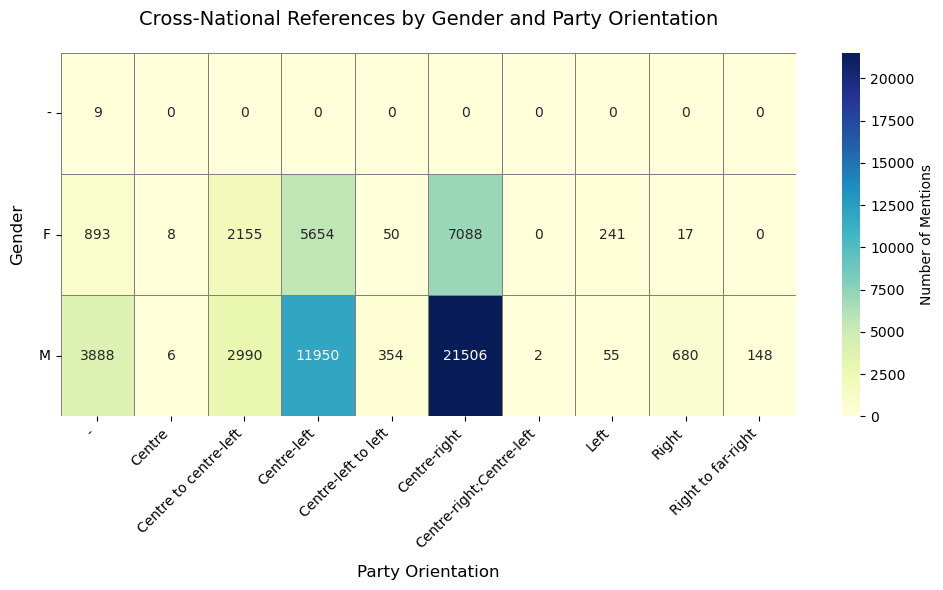

In [18]:
# Aggregate mentions by gender and party orientation
combined_mentions = df_foreign.groupby(["Speaker_gender", "Party_orientation"]).size().reset_index(name='count')

# Pivot for heatmap
pivot_combined = combined_mentions.pivot(index="Speaker_gender", 
                                       columns="Party_orientation", 
                                       values="count").fillna(0)

# Create heatmap with enhanced styling
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_combined, 
            annot=True,              # Show numbers in cells
            fmt=".0f",              # Format as integers
            cmap="YlGnBu",          # Color scheme
            cbar_kws={'label': 'Number of Mentions'},  # Colorbar label
            linewidths=0.5,         # Add lines between cells
            linecolor='gray',       # Line color
            annot_kws={'size': 10}) # Size of numbers in cells

# Customize plot
plt.title("Cross-National References by Gender and Party Orientation", 
          fontsize=14, 
          pad=20)
plt.xlabel("Party Orientation", 
           fontsize=12, 
           labelpad=10)
plt.ylabel("Gender", 
           fontsize=12, 
           labelpad=10)

# Rotate labels if needed
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()


Missing Values in Speaker Data:
Speaker_gender        0
Speaker_party        13
Party_orientation     0
dtype: int64
Average Mentions by Gender:
  Speaker_gender   Mentions
0              -   9.000000
1              F  31.893069
2              M  35.356293
Chi-squared test for Gender and High Mentions: chi2=4.208, p-value=0.122


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17772\1116316581.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_mentions, x='Speaker_gender', y='Mentions', palette='Set2')


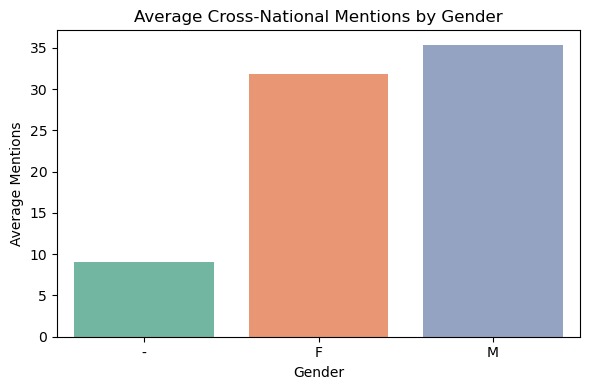

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17772\1116316581.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_speakers, x='Speaker_gender', y='Mentions', palette='Set2')


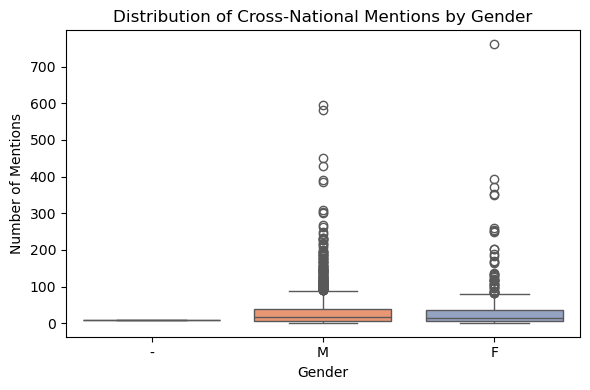

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17772\1116316581.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_parties.groupby('Speaker_party')['Mentions'].mean().reset_index(),


Average Mentions by Party:
   Speaker_party   Mentions
0              -  12.000000
1              A  11.500000
2             BI  10.096774
3             CB  24.400000
4            CON  39.435506
5         CON;NA  29.000000
6            DUP  46.466667
7             GP  75.666667
8              I   5.200000
9             IL  29.000000
10          L8TA  19.000000
11           LAB  28.190855
12        LAB;NA   3.000000
13            LD  39.141791
14            PC  67.666667
15          QMZZ   4.000000
16          SDLP  24.600000
17           SNP  53.200000
18          UKIP  29.600000
19           UUP  25.250000
20          ZKPW  25.000000
Chi-squared test for Party and High Mentions: chi2=51.421, p-value=0.000


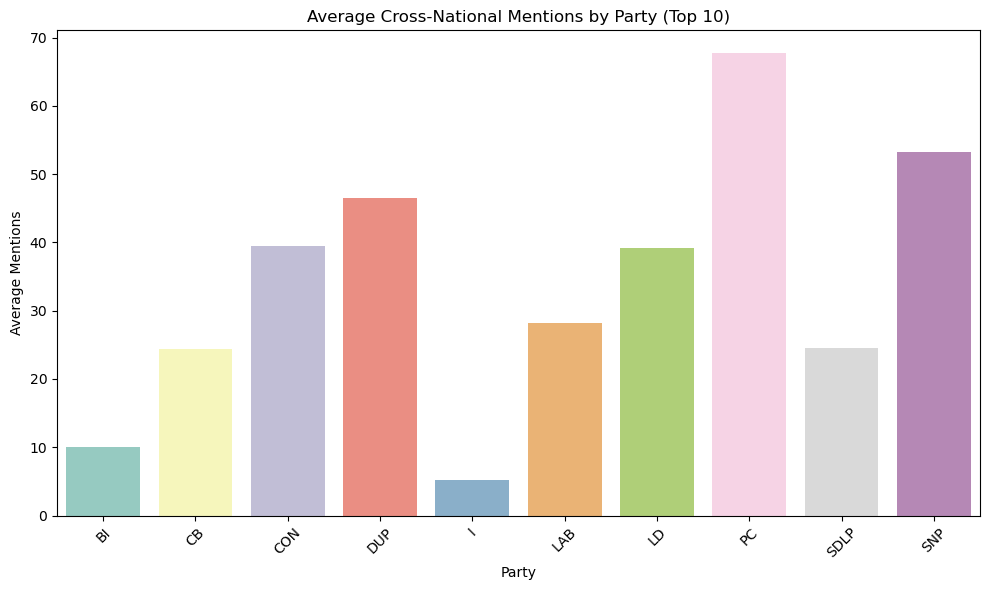

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17772\1116316581.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_parties, x='Speaker_party', y='Mentions', palette='Set3')


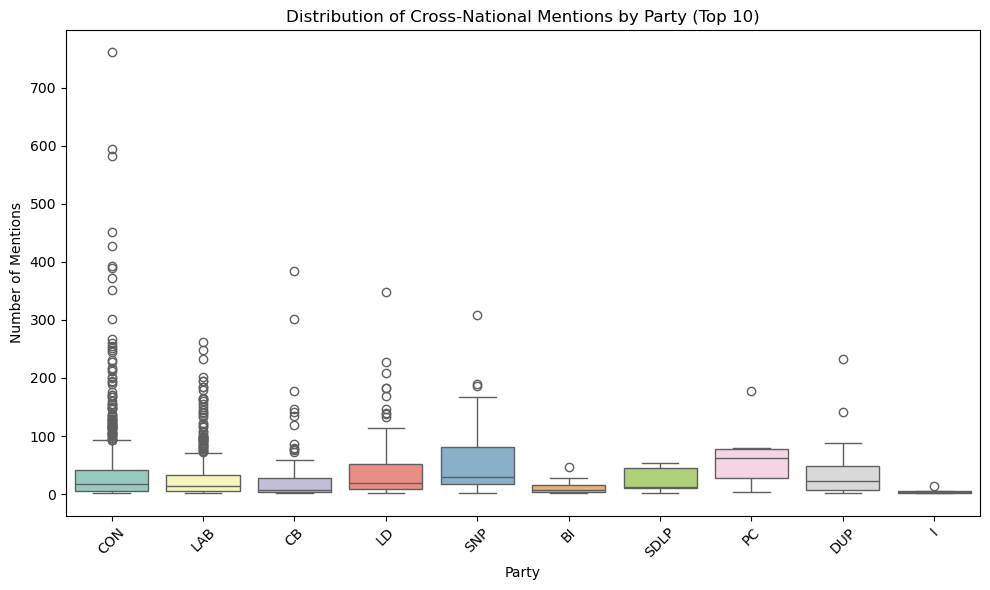

Average Mentions by Party Orientation:
       Party_orientation   Mentions
0                      -  21.322430
1  Centre to centre-left  38.735294
2            Centre-left  30.937391
3    Centre-left to left  67.666667
4           Centre-right  39.294360
5                   Left  64.000000
6                  Right  46.466667
7     Right to far-right  29.600000
Chi-squared test for Party Orientation and High Mentions: chi2=30.463, p-value=0.000


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17772\1116316581.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=orientation_mentions, x='Party_orientation', y='Mentions', palette='Set1')


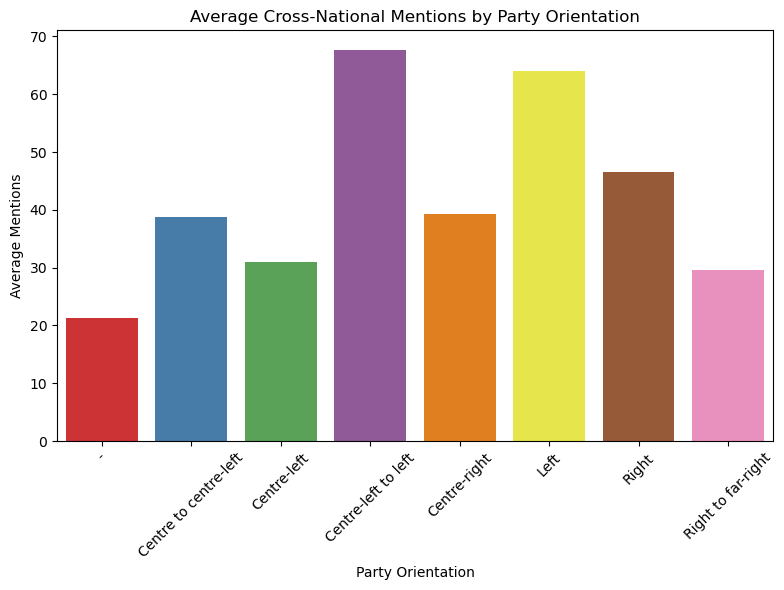

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17772\1116316581.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_speakers, x='Party_orientation', y='Mentions', palette='Set1')


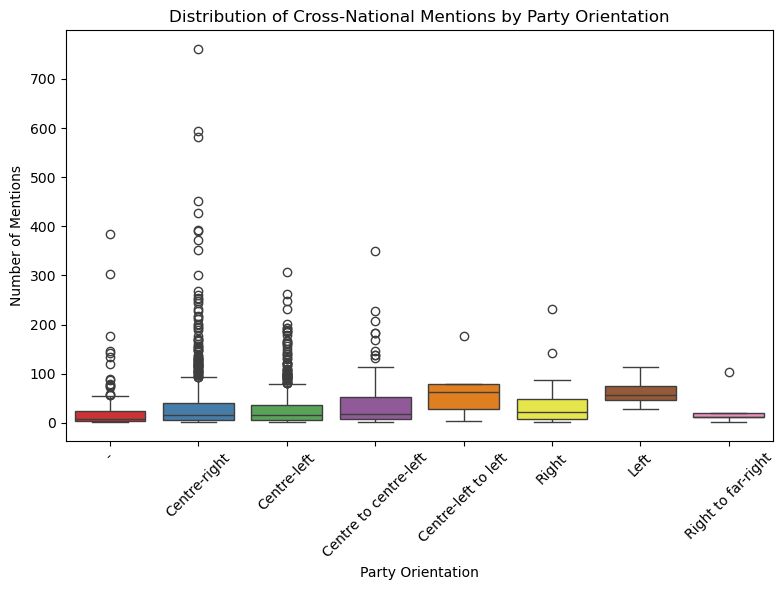

Linear Regression Coefficients for Cross-National Mentions:
                     Coefficient
Gender_Encoded          3.317197
Party_Encoded           0.540658
Orientation_Encoded     4.106955
R-squared: 0.011


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder


df = df_foreign
# Step 1: Aggregate mentions by Speaker_ID to get total mentions per speaker
speaker_mentions = df.groupby('Speaker_ID').size().reset_index(name='Mentions')
# Merge with speaker details (drop duplicates to keep unique speaker info)
speaker_info = df[['Speaker_ID', 'Speaker_gender', 'Speaker_party', 'Speaker_party_name', 'Party_orientation']].drop_duplicates(subset='Speaker_ID')
df_speakers = pd.merge(speaker_mentions, speaker_info, on='Speaker_ID', how='left')

# Add a binary variable for high/low mentions (above/below median)
df_speakers['High_Mentions'] = df_speakers['Mentions'] > df_speakers['Mentions'].median()

# Check for missing values in key columns
print("Missing Values in Speaker Data:")
print(df_speakers[['Speaker_gender', 'Speaker_party', 'Party_orientation']].isnull().sum())

# 1. Association with Gender
gender_mentions = df_speakers.groupby('Speaker_gender')['Mentions'].mean().reset_index()
print("Average Mentions by Gender:")
print(gender_mentions)

# Chi-squared test for association between Gender and High_Mentions
contingency_gender = pd.crosstab(df_speakers['Speaker_gender'], df_speakers['High_Mentions'])
chi2_gender, p_gender, dof_gender, expected_gender = chi2_contingency(contingency_gender)
print(f"Chi-squared test for Gender and High Mentions: chi2={chi2_gender:.3f}, p-value={p_gender:.3f}")

# Visualization: Bar plot for Gender
plt.figure(figsize=(6, 4))
sns.barplot(data=gender_mentions, x='Speaker_gender', y='Mentions', palette='Set2')
plt.title('Average Cross-National Mentions by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Mentions')
plt.tight_layout()
plt.show()

# Visualization: Boxplot for Gender
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_speakers, x='Speaker_gender', y='Mentions', palette='Set2')
plt.title('Distribution of Cross-National Mentions by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Mentions')
plt.tight_layout()
plt.show()

# 2. Association with Speaker Party
party_mentions = df_speakers.groupby('Speaker_party')['Mentions'].mean().reset_index()
print("Average Mentions by Party:")
print(party_mentions)

# Chi-squared test for Party and High_Mentions (limit to top parties if too many)
top_parties = df_speakers['Speaker_party'].value_counts().head(10).index
df_top_parties = df_speakers[df_speakers['Speaker_party'].isin(top_parties)]
contingency_party = pd.crosstab(df_top_parties['Speaker_party'], df_top_parties['High_Mentions'])
chi2_party, p_party, dof_party, expected_party = chi2_contingency(contingency_party)
print(f"Chi-squared test for Party and High Mentions: chi2={chi2_party:.3f}, p-value={p_party:.3f}")

# Visualization: Bar plot for Party (top parties)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top_parties.groupby('Speaker_party')['Mentions'].mean().reset_index(), 
            x='Speaker_party', y='Mentions', palette='Set3')
plt.title('Average Cross-National Mentions by Party (Top 10)')
plt.xlabel('Party')
plt.ylabel('Average Mentions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization: Boxplot for Party
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_top_parties, x='Speaker_party', y='Mentions', palette='Set3')
plt.title('Distribution of Cross-National Mentions by Party (Top 10)')
plt.xlabel('Party')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Association with Party Orientation
orientation_mentions = df_speakers.groupby('Party_orientation')['Mentions'].mean().reset_index()
print("Average Mentions by Party Orientation:")
print(orientation_mentions)

# Chi-squared test for Party Orientation and High_Mentions
contingency_orientation = pd.crosstab(df_speakers['Party_orientation'], df_speakers['High_Mentions'])
chi2_orientation, p_orientation, dof_orientation, expected_orientation = chi2_contingency(contingency_orientation)
print(f"Chi-squared test for Party Orientation and High Mentions: chi2={chi2_orientation:.3f}, p-value={p_orientation:.3f}")

# Visualization: Bar plot for Party Orientation
plt.figure(figsize=(8, 6))
sns.barplot(data=orientation_mentions, x='Party_orientation', y='Mentions', palette='Set1')
plt.title('Average Cross-National Mentions by Party Orientation')
plt.xlabel('Party Orientation')
plt.ylabel('Average Mentions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization: Boxplot for Party Orientation
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_speakers, x='Party_orientation', y='Mentions', palette='Set1')
plt.title('Distribution of Cross-National Mentions by Party Orientation')
plt.xlabel('Party Orientation')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Regression Analysis (Combined Effect of Variables)
# Encode categorical variables
le_gender = LabelEncoder()
le_party = LabelEncoder()
le_orientation = LabelEncoder()

df_speakers['Gender_Encoded'] = le_gender.fit_transform(df_speakers['Speaker_gender'])
df_speakers['Party_Encoded'] = le_party.fit_transform(df_speakers['Speaker_party'])
df_speakers['Orientation_Encoded'] = le_orientation.fit_transform(df_speakers['Party_orientation'])

# Features and target
X = df_speakers[['Gender_Encoded', 'Party_Encoded', 'Orientation_Encoded']]
y = df_speakers['Mentions']

# Linear regression
model = LinearRegression()
model.fit(X, y)

# Coefficients
coefficients = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient'])
print("Linear Regression Coefficients for Cross-National Mentions:")
print(coefficients)
print(f"R-squared: {model.score(X, y):.3f}")
